In [66]:
import gym
import gym.wrappers
import numpy as np
import logging
import joblib
import matplotlib.pylab as pl
import threading
%matplotlib inline

from tqdm import tqdm_notebook as tqdm

In [67]:
gym.logger.setLevel(logging.ERROR)
env = gym.make("LunarLander-v2")
# if isinstance(env, gym.wrappers.TimeLimit):
#     env._max_episode_steps = max_steps
#env = gym.wrappers.Monitor(env, "mountaincar-res")

n_actions = env.action_space.n

print("n_actions=%i" % (n_actions))

n_actions=4


In [68]:
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(40,40),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
#initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()]*n_actions,range(n_actions));

/home/shmuma/anaconda3/envs/pract_rl/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


In [69]:
def generate_session(t_max=10000):
    loc_data = threading.local()
    if not hasattr(loc_data, "env"):
        loc_data.env = gym.make("LunarLander-v2")
    env = loc_data.env
    states, actions = [], []
    total_reward = 0
    s = env.reset()
    
    for _ in range(t_max):
        probs = agent.predict_proba([s])[0]
        a = np.random.choice(n_actions, p=probs)
        new_s, r, done, _ = env.step(a)
        states.append(s)
        actions.append(a)
        total_reward += r
        s = new_s
        if done:
            break
    
    return states, actions, total_reward

In [70]:
n_jobs = 4
n_samples = 500
percentile = 50
rewards = []
thresholds = []

In [73]:
percentile = 40
n_samples = 500
rewards = []
thresholds = []

In [ ]:
for i in range(100):
    # it's essential to create new pool of workers every time
    #%time 
    sessions = joblib.Parallel(n_jobs)(joblib.delayed(generate_session)() for _ in range(n_samples))
    batch_states, batch_actions, batch_rewards = map(np.array, zip(*sessions))

    threshold = np.percentile(batch_rewards, percentile)
    elite_states = batch_states[batch_rewards > threshold]
    elite_actions = batch_actions[batch_rewards > threshold]

    if not elite_states.size:
        print("%d: no elite sessions, try again" % i)
        continue

    elite_states, elite_actions = map(np.concatenate, [elite_states, elite_actions])

    agent.fit(elite_states, elite_actions)
    print("%d: mean reward = %.5f (max: %f)\tthreshold = %.1f" % (
        i, np.mean(batch_rewards), np.max(batch_rewards), threshold))
    thresholds.append(threshold)
    rewards.append(np.mean(batch_rewards))

0: mean reward = -23.32533 (max: 188.928599)	threshold = -14.9
1: mean reward = -23.67996 (max: 186.886257)	threshold = -15.7
2: mean reward = -15.52571 (max: 241.022867)	threshold = -14.2
3: mean reward = -7.21091 (max: 184.619889)	threshold = -11.4
4: mean reward = -6.53283 (max: 179.524921)	threshold = -9.9
5: mean reward = -10.35509 (max: 132.769350)	threshold = -13.4
6: mean reward = -3.62665 (max: 203.793064)	threshold = -12.1
7: mean reward = -4.19189 (max: 180.279122)	threshold = -9.1
8: mean reward = -8.52725 (max: 213.445741)	threshold = -11.1
9: mean reward = -2.41902 (max: 194.079680)	threshold = -10.4
10: mean reward = -3.80759 (max: 179.029426)	threshold = -8.2
11: mean reward = 4.45655 (max: 220.015085)	threshold = -5.2
12: mean reward = -3.31922 (max: 161.526512)	threshold = -7.2
13: mean reward = -0.30311 (max: 199.860849)	threshold = -5.5
14: mean reward = 0.49324 (max: 220.512526)	threshold = -7.4
15: mean reward = 0.98956 (max: 202.550626)	threshold = -3.1
16: mean 

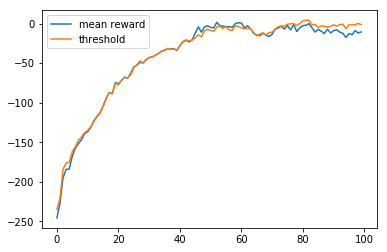

In [72]:
pl.plot(rewards, label='mean reward')
pl.plot(thresholds, label='threshold')
pl.legend()
pl.show()

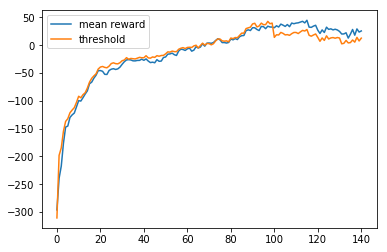

In [65]:
pl.plot(rewards, label='mean reward')
pl.plot(thresholds, label='threshold')
pl.legend()
pl.show()